# CNeuromod Mario Tutorial

## Complete Analysis Pipeline: From GLM to Brain Encoding

<br>

**This series of notebooks covers:**
- Dataset organization and behavioral annotations
- GLM analysis: Actions and game events
- RL agent: Learning representations from gameplay
- Brain encoding: Predicting fMRI from learned features

<br>

---

*Yann Harel @ MAIN Educational 2025*
<div align="center">
  <img src="../images/logos/logo_neuromod_black.png" alt="CNeuromod Logo" width="500"/>
</div>


# Part 0: Dataset Organization and Behavioral Annotations

# Introduction

In [9]:
# @title Environment Setup
# @markdown Run this cell to set up the environment and download the necessary data.

import os
import sys
import subprocess
from pathlib import Path

# Configuration
REPO_URL = "https://github.com/courtois-neuromod/mario.tutorials.git"
PROJECT_PATH = Path("/content/mario.tutorials")
REQUIREMENTS_FILE = "notebooks/02_requirements.txt"

# Detect Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("🚀 Detected Google Colab. Setting up ephemeral environment...")
    
    # 1. Clone Repository
    if not PROJECT_PATH.exists():
        !git clone {REPO_URL} {PROJECT_PATH}
        !cd {PROJECT_PATH}
    else:
        !cd {PROJECT_PATH} && git pull
    
    os.chdir(PROJECT_PATH)
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    !pip install -r notebooks/00_requirements.txt
    
else:
    print("💻 Detected Local Environment.")
    if Path.cwd().name == 'notebooks':
        os.chdir(Path.cwd().parent)
    sys.path.insert(0, str(Path.cwd() / "src"))
    print(f"✅ Ready. Working directory: {os.getcwd()}")

💻 Detected Local Environment.
✅ Ready. Working directory: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials


## 📊 What is CNeuromod?

**The Courtois Project on Neural Modelling (CNeuromod)** is an open deep phenotyping dataset to build individual models of the brain.

- **5 subjects** scanned extensively (200+ hours each)
- **Multiple paradigms:** Movies, video games, cognitive tasks
- **Deep phenotyping:** Anatomical, functional, behavioral data, several brain modalities
- **Fully open:** Data and code publicly available, collaborative mindset

---

- https://www.cneuromod.ca/
- https://docs.cneuromod.ca/en/latest/
- https://github.com/courtois-neuromod/

## 🎮 CNeuromod Mario: Playing Super Mario Bros in the Scanner

**Why play videogames in a scanner ?**
- Active naturalistic paradigms, well-controled
- Engaging task, warrants human compliance
- Common ground for humans and AI

<br>

**And why Super Mario Bros. ?**
- Objectively good game, many sequels
- Simple but rich gameplay
- Active players and modders communities
- "Easy" for humans, challenging for AIs


## 🍄 Dataset overview

**5 participants** playing Super Mario Bros. (Nintendo, 1983) via [gym-retro](https://github.com/Farama-Foundation/stable-retro)

About **84h** of total combined gameplay

**22 levels**, excluded Waterworld and Bowser castle

**Discovery phase**: complete levels sequentially  
**Practice phase**: play levels in random order

---

#### Data modalities

- **Functional MRI:** Accelerated simultaneous multi-slice (SMS) gradient echo-planar imaging, 2mm isotropic voxels, TR=1.49s
- **Anatomical MRI:** T1-weighted MPRAGE, T2-weighted FSE, Diffusion-weighted (acquired separately)
- **Physiological:** Plethysmography, skin conductance, ECG, respiration, eye-tracking
- **Behavioral:** Frame-by-frame gameplay (60Hz), controller inputs, and event logs


## 📁 This Notebook Covers


**1. Dataset Management**

**2. Rich Behavioral Annotations**

**3. Descriptive Statistics**

---

*Let's dive into the data! 🚀*

## 1. Dataset management

### BIDS Data Organization

**Brain Imaging Data Structure (BIDS)** is a standardized format for organizing neuroimaging data.

**Core principles:**
- Consistent file naming: `sub-<ID>_ses-<N>_task-<name>_run-<N>_<type>.nii.gz`
- Predictable folder hierarchy: `sub-XX/ses-YY/func/`
- Works automatically with analysis tools (fMRIPrep, etc.)
- Easy to share and understand

### Where to Find What You Need

The Mario dataset follows the **Brain Imaging Data Structure (BIDS)** standard:

```
sourcedata/
├── mario/                           # Raw BIDS dataset
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_events.tsv     # Basic event timing
│               ├── *_bold.nii.gz    # Raw functional scans
│               └── ...
│
├── mario.fmriprep/                  # Preprocessed BOLD data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_desc-preproc_bold.nii.gz      # Preprocessed BOLD
│               ├── *_desc-brain_mask.nii.gz        # Brain mask
│               ├── *_desc-confounds_timeseries.tsv # Motion/physio confounds
│               └── ...
│
├── mario.annotations/               # Rich behavioral annotations
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               └── *_desc-annotated_events.tsv     # Actions + game events
│
├── mario.replays/                   # Frame-by-frame gameplay data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── confs/*.npy      # Low-level features (luminance, etc.)
│               ├── infos/*.json     # Metadata: duration, cleared, phase
│               ├── ramdumps/        # Raw emulator state
│               ├── variables/       # Game state variables
│               └── videos/*.mp4     # Full gameplay video
│
├── mario.scenes/                    # Level segmentation and scene-based events
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── infos/*.json        # Scene metadata and clip info
│               ├── videos/*.mp4        # Video clips of the scenes
│               └── ...
│
└── cneuromod.processed/             # Anatomical templates
    └── smriprep/
        └── sub-{01,02,03,05,06}/
            └── anat/
                ├── *_MNI152NLin2009cAsym_preproc.nii.gz  # T1w in MNI space
                └── ...
```

**Key Files for Analysis:**

| Data Type | Location | Use Case |
|-----------|----------|----------|
| **Preprocessed BOLD** | `mario.fmriprep/*/*/func/*_desc-preproc_bold.nii.gz` | GLM, encoding models |
| **Brain mask** | `mario.fmriprep/*/*/func/*_desc-brain_mask.nii.gz` | Restrict analysis to brain |
| **Confounds** | `mario.fmriprep/*/*/func/*_desc-confounds_timeseries.tsv` | Motion/physiology regressors |
| **Rich annotated events** | `mario.annotations/*/*/func/*_desc-annotated_events.tsv` | Button presses, game events |
| **Replay metadata** | `mario.replays/*/*/beh/infos/*.json` | Success/failure, duration, phase |
| **Replay video clips** | `mario.replays/*/*/beh/videos/*.mp4` | Visualizing gameplay |
| **Scene metadata** | `mario.scenes/*/*/beh/infos/*.json` | Scene timing, level, and clip details |
| **Scene video clips** | `mario.scenes/*/*/beh/videos/*.mp4` | Visualizing specific scenes |
| **Low-level features** | `mario.replays/*/*/beh/confs/*.npy` | Luminance, optical flow, audio |
| **Anatomical** | `cneuromod.processed/smriprep/*/anat/*_MNI*.nii.gz` | Registration, visualization |

### Download with datalad
To ensure reproducibility and manage large datasets efficiently, we use **DataLad**.

**The Setup Process:**
1. **Install datasets** with `datalad install`
   - **Raw BIDS:** `mario/`
   - **Preprocessed:** `mario.fmriprep/sub-01`
   - **Anatomical:** `cneuromod.processed`
   
2. **Fetch the data** with `datalad get`


In [10]:
# Check if data exists, if not download with datalad
from pathlib import Path

sourcedata = Path("./sourcedata")

if not sourcedata.exists():
    print("Installing datasets with datalad...")
    
    if IN_COLAB:
        
        # Install git-annex standalone (apt version is too old)
        !wget -q https://downloads.kitenet.net/git-annex/linux/current/git-annex-standalone-amd64.tar.gz
        !tar -xzf git-annex-standalone-amd64.tar.gz && rm git-annex-standalone-amd64.tar.gz
        import os
        os.environ['PATH'] = f"{Path.cwd()}/git-annex.linux:{os.environ['PATH']}"
        
        !pip install -q datalad datalad-osf
        !mkdir -p sourcedata && cd sourcedata
        !datalad install https://github.com/courtois-neuromod/mario
        !datalad install https://github.com/courtois-neuromod/mario.replays
        !datalad install https://github.com/courtois-neuromod/mario.annotations
        !cd mario && datalad get sub-*/ses-*/func/*_events.tsv
        
    else:
        !mkdir -p sourcedata && cd sourcedata
        !datalad install https://github.com/courtois-neuromod/mario
        !datalad install https://github.com/courtois-neuromod/mario.replays
        !datalad install https://github.com/courtois-neuromod/mario.annotations
        !cd mario && datalad get sub-*/ses-*/func/*_events.tsv
    
    print("\n✓ Data ready!")
    
else:
    print("✓ Datasets already installed")

✓ Datasets already installed


In [11]:
# Load replay metadata from JSON files in mario.replays
from pathlib import Path
import json
import pandas as pd

sourcedata_path = Path("./sourcedata")
replays_path = sourcedata_path / "mario.replays"

# Find all JSON metadata files
json_files = sorted(replays_path.glob("sub-*/ses-*/beh/infos/*.json"))
print(f"Found {len(json_files)} replay metadata files in mario.replays")

# Load all JSONs into a dataframe
all_data = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
        all_data.append(data)

replay_data = pd.DataFrame(all_data)

print(f"Loaded {len(replay_data)} replays from {len(replay_data['Subject'].unique())} subjects")

Found 3374 replay metadata files in mario.replays
Loaded 3374 replays from 5 subjects


In [12]:
# Load and display dataset statistics
from utils import compute_dataset_statistics

compute_dataset_statistics(replay_data)

Loading dataset statistics...

PER-SUBJECT STATISTICS
Subject  Total Repetitions  Successful Completions  Failures  Success Rate (%)  Total Duration (min)  Sessions
 sub-01                797                     576       221              72.3                 821.6        21
 sub-02                714                     418       296              58.5                1048.0        23
 sub-03                627                     391       236              62.4                1007.0        29
 sub-05                634                     331       303              52.2                1077.8        22
 sub-06                602                     485       117              80.6                1083.4        25

DATASET-WIDE STATISTICS
  Total Repetitions............................ 3374
  Total Successful Completions................. 2201
  Total Failures............................... 1173
  Overall Success Rate (%)..................... 65.2
  Total Playtime (hours)...................

## Behavioral Annotations

The `mario.annotations` dataset provides three types of events:

**1. Action events (button presses):**
- A, B, LEFT, RIGHT, UP, DOWN
- Precise onset and duration
- **Button mappings:**
  - **A = JUMP** (short taps, mean duration ~0.3s)
  - **B = RUN/FIREBALL** (held continuously, mean duration ~12s)
  - LEFT/RIGHT = Movement
  - UP = Enter pipe, DOWN = Crouch

**2. Game events:**
- Kill/stomp, Kill/kick (defeating enemies)
- Hit/life_lost (player damage)
- Powerup_collected, Coin_collected (rewards)
- Flag_reached (level completion)

**3. Scene information:**
- Level segmentation
- Unique scene codes for each game section

Let's load and visualize these events!

In [13]:
# Define constants and load annotated events
import pandas as pd
from pathlib import Path

# Constants
SUBJECT = 'sub-01'
SESSION = 'ses-010'

# Load annotated events from mario.annotations
annotations_path = Path("./sourcedata/mario.annotations")
events_path = annotations_path / SUBJECT / SESSION / "func" / f"{SUBJECT}_{SESSION}_task-mario_run-01_desc-annotated_events.tsv"

if events_path.exists():
    events = pd.read_csv(events_path, sep='\t')
    
    # Define event categories
    button_events = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    game_events = ['Kill/stomp', 'Kill/kick', 'Hit/life_lost', 'Powerup_collected', 'Coin_collected', 'Flag_reached']
    
    # Count events by type
    n_buttons = events[events['trial_type'].isin(button_events)].shape[0]
    n_game = events[events['trial_type'].isin(game_events)].shape[0]
    
    # Get all events for this session across all runs
    session_events = []
    all_events = []
    runs = []
    
    for run_file in sorted((annotations_path / SUBJECT / SESSION / "func").glob(f"{SUBJECT}_{SESSION}_task-mario_run-*_desc-annotated_events.tsv")):
        run_events = pd.read_csv(run_file, sep='\t')
        session_events.append(run_events)
        all_events.append(run_events)
        runs.append(run_file.stem.split('_')[3])  # Extract run number
    
    session_events = pd.concat(session_events, ignore_index=True)
    EVENTS_LOADED = True
    
    print(f"✓ Loaded events for {SUBJECT} {SESSION}")
    print(f"  Total events: {len(session_events)}")
    print(f"  Button presses: {n_buttons}")
    print(f"  Game events: {n_game}")
else:
    print(f"✗ Events file not found: {events_path}")
    EVENTS_LOADED = False

✓ Loaded events for sub-01 ses-010
  Total events: 3864
  Button presses: 844
  Game events: 87


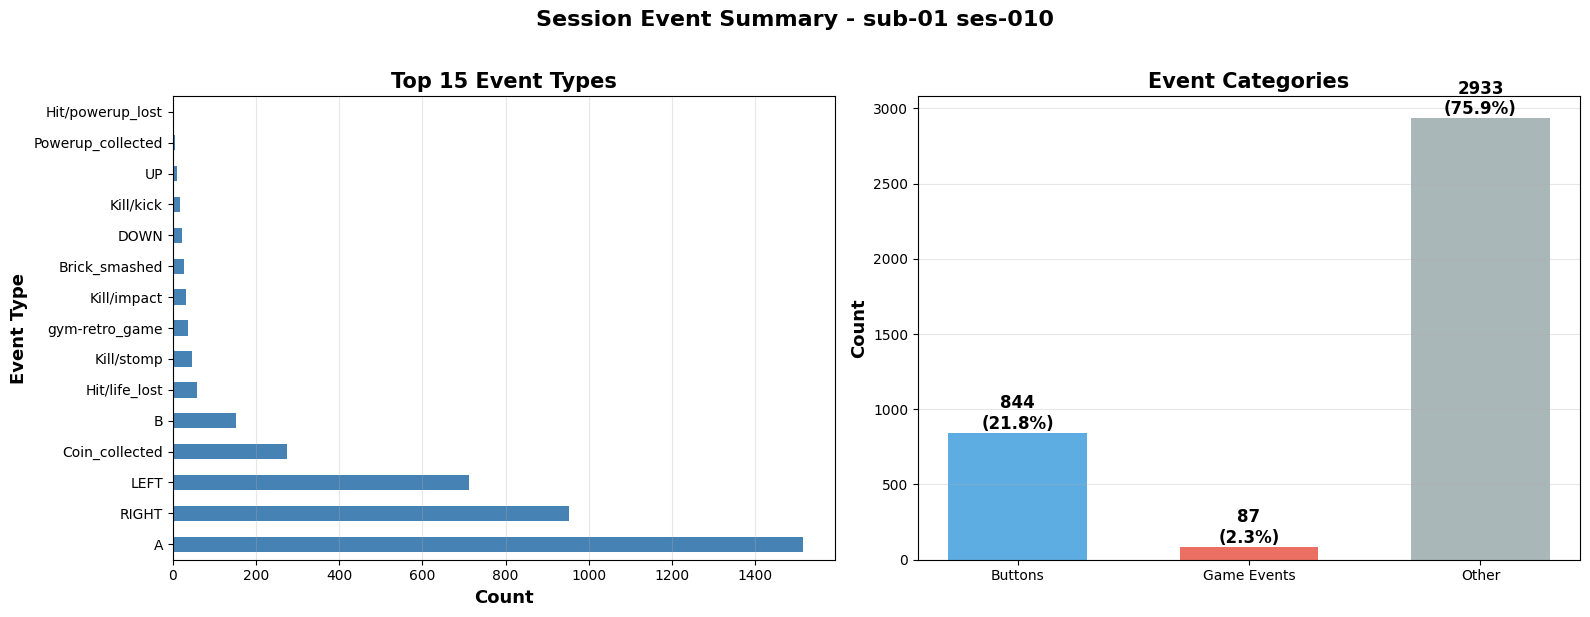

In [14]:
# Visualize event frequencies
import matplotlib.pyplot as plt
from glm_utils import plot_event_frequencies

fig = plot_event_frequencies(
    session_events, n_buttons, n_game,
    SUBJECT, SESSION
)
plt.show()

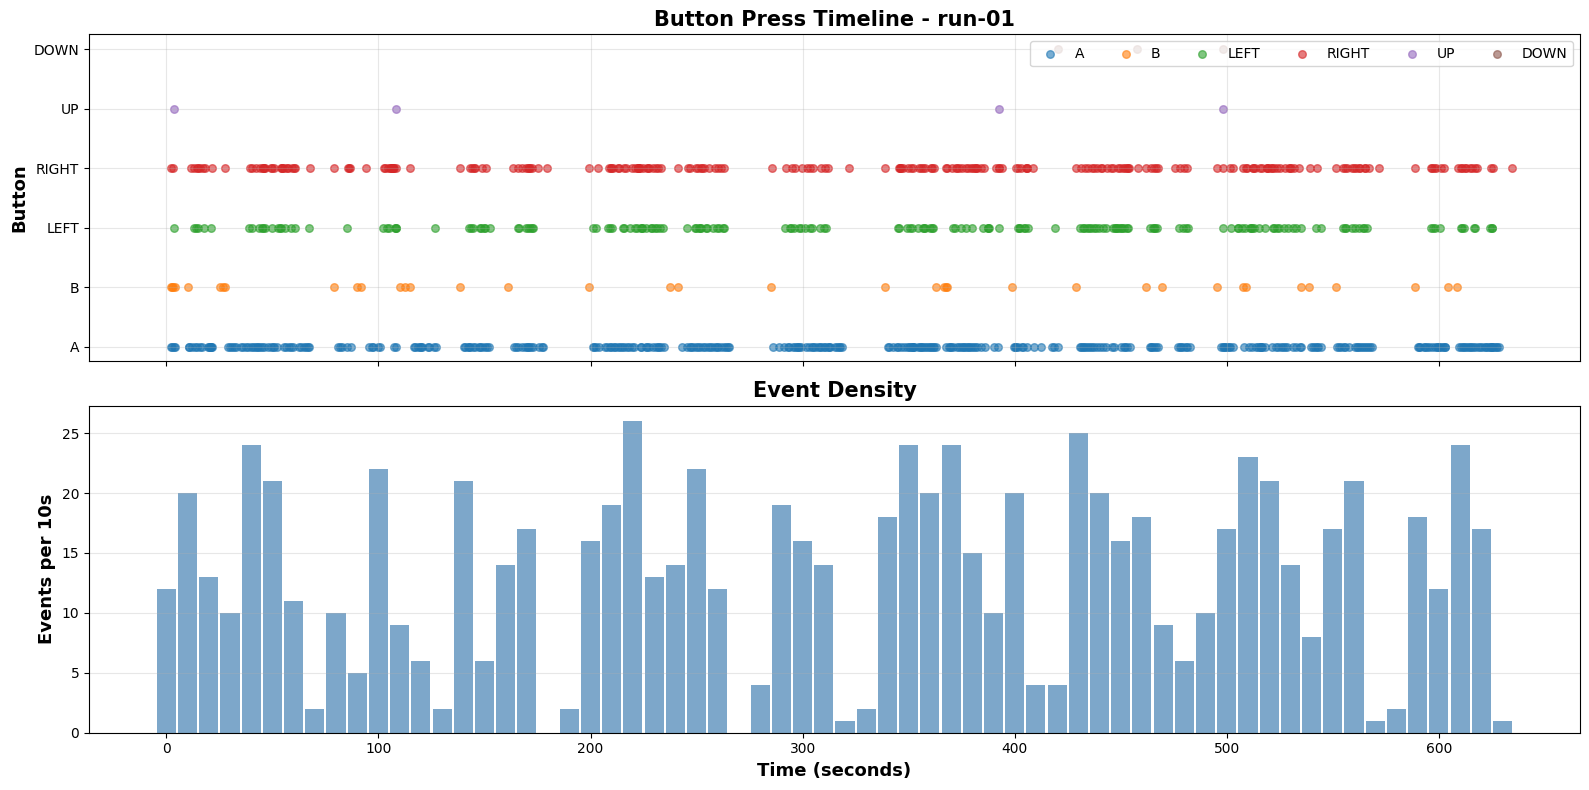

In [15]:
# Event timeline for first run
import matplotlib.pyplot as plt
from glm_utils import plot_event_timeline

if EVENTS_LOADED and len(all_events) > 0:
    fig = plot_event_timeline(all_events[0], runs[0], button_events)
    plt.show()
else:
    print("Timeline not available.")